In [ ]:
from google.colab import drive
import zipfile
import os

# 1. 구글 드라이브 마운트
drive.mount('/content/drive')

# 2. 경로 설정 (사용자 환경에 맞게 수정 가능)
# 구글 드라이브 내 zip 파일이 있는 경로를 입력하세요.
zip_path = '/content/drive/MyDrive/Sample.zip'

# 압축을 풀 폴더 경로
extract_path = '/content/dataset'

# 3. 압축 해제 진행
if os.path.exists(zip_path):
    # 폴더가 없으면 생성
    os.makedirs(extract_path, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
        print(f"압축 해제가 완료되었습니다: {extract_path}")
else:
    print("파일 경로를 확인해주세요. 'Sample.zip'이 해당 위치에 없습니다.")

Mounted at /content/drive
압축 해제가 완료되었습니다: /content/dataset


In [ ]:
import os

for root, dirs, files in os.walk("/content/dataset"):
    print(root)
    print("dirs:", dirs)
    print("files:", files[:5])
    print("-"*40)


/content/dataset
dirs: ['Sample']
files: []
----------------------------------------
/content/dataset/Sample
dirs: ['02.라벨링데이터', '01.원천데이터']
files: []
----------------------------------------
/content/dataset/Sample/02.라벨링데이터
dirs: ['Exterior_Img_Datasets', 'CT_Datasets']
files: []
----------------------------------------
/content/dataset/Sample/02.라벨링데이터/Exterior_Img_Datasets
dirs: ['label']
files: []
----------------------------------------
/content/dataset/Sample/02.라벨링데이터/Exterior_Img_Datasets/label
dirs: []
files: ['RGB_cell_cylindrical_0040_186.json', 'RGB_cell_cylindrical_0041_131.json', 'RGB_cell_cylindrical_0040_126.json', 'RGB_cell_cylindrical_0041_035.json', 'RGB_cell_cylindrical_0001_267.json']
----------------------------------------
/content/dataset/Sample/02.라벨링데이터/CT_Datasets
dirs: ['label']
files: []
----------------------------------------
/content/dataset/Sample/02.라벨링데이터/CT_Datasets/label
dirs: []
files: ['CT_cell_pouch_101_y_086.json', 'CT_cell_pouch_101_y_280.json

In [ ]:
IMG_DIR = "/content/dataset/Sample/01.원천데이터/Exterior_Img_Datasets/images"
LBL_DIR = "/content/dataset/Sample/02.라벨링데이터/Exterior_Img_Datasets/label"


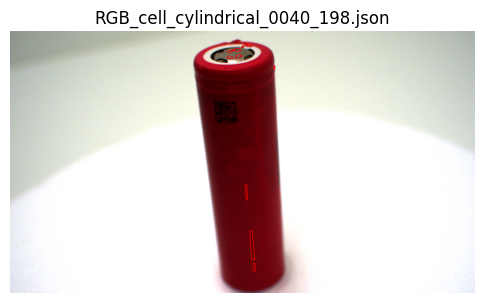

In [ ]:
import json
import cv2
import matplotlib.pyplot as plt
import os
import random

# 샘플 하나 랜덤 선택
json_files = os.listdir(LBL_DIR)
json_name = random.choice(json_files)

img_name = json_name.replace(".json", ".png")

img_path = os.path.join(IMG_DIR, img_name)
json_path = os.path.join(LBL_DIR, json_name)

# 이미지 로드 (RGB)
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# JSON 로드
with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# Polygon 그리기
for defect in data.get("defects", []):
    pts = defect["points"]
    xs = pts[0::2]
    ys = pts[1::2]

    polygon = list(zip(xs, ys))
    polygon = [(int(x), int(y)) for x, y in polygon]

    for i in range(len(polygon)):
        cv2.line(
            img,
            polygon[i],
            polygon[(i + 1) % len(polygon)],
            (255, 0, 0),
            2
        )

plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(json_name)
plt.axis("off")
plt.show()


In [ ]:
import json
import cv2
import numpy as np
import os

def load_image_and_mask(img_path, json_path):
    # RGB 이미지 로드
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    # 빈 mask 생성 (binary)
    mask = np.zeros((h, w), dtype=np.uint8)

    # JSON 로드
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    for defect in data.get("defects", []):
        pts = defect["points"]
        xs = pts[0::2]
        ys = pts[1::2]

        polygon = np.array(
            [[int(x), int(y)] for x, y in zip(xs, ys)],
            dtype=np.int32
        )

        # polygon 채우기
        cv2.fillPoly(mask, [polygon], 1)

    return img, mask


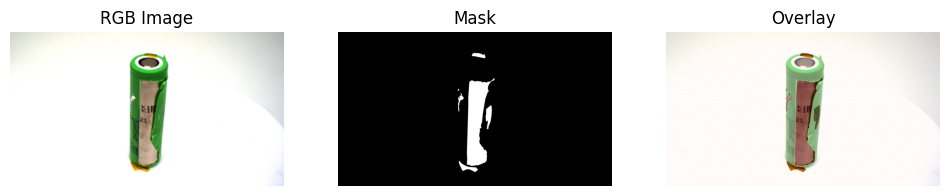

In [ ]:
import matplotlib.pyplot as plt
import random

json_files = os.listdir(LBL_DIR)
json_name = random.choice(json_files)
img_name = json_name.replace(".json", ".png")

img_path = os.path.join(IMG_DIR, img_name)
json_path = os.path.join(LBL_DIR, json_name)

img, mask = load_image_and_mask(img_path, json_path)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("RGB Image")
plt.imshow(img)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Mask")
plt.imshow(mask, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Overlay")
plt.imshow(img)
plt.imshow(mask, alpha=0.4, cmap="Reds")
plt.axis("off")

plt.show()


In [ ]:
import os
import json
import cv2
import shutil
from tqdm import tqdm

IMG_DIR = "/content/dataset/Sample/01.원천데이터/Exterior_Img_Datasets/images"
LBL_DIR = "/content/dataset/Sample/02.라벨링데이터/Exterior_Img_Datasets/label"

OUT_ROOT = "/content/yolo_seg_dataset"
IMG_OUT = os.path.join(OUT_ROOT, "images")
LBL_OUT = os.path.join(OUT_ROOT, "labels")

for split in ["train", "val"]:
    os.makedirs(os.path.join(IMG_OUT, split), exist_ok=True)
    os.makedirs(os.path.join(LBL_OUT, split), exist_ok=True)

# train/val split (8:2)
json_files = sorted(os.listdir(LBL_DIR))
split_idx = int(len(json_files) * 0.8)
train_files = json_files[:split_idx]
val_files = json_files[split_idx:]

def convert(json_list, split):
    for json_name in tqdm(json_list):
        img_name = json_name.replace(".json", ".png")

        img_path = os.path.join(IMG_DIR, img_name)
        json_path = os.path.join(LBL_DIR, json_name)

        if not os.path.exists(img_path):
            continue

        img = cv2.imread(img_path)
        h, w, _ = img.shape

        with open(json_path, "r", encoding="utf-8") as f:
            data = json.load(f)

        yolo_lines = []

        for defect in data.get("defects", []):
            pts = defect["points"]

            norm_pts = []
            for i in range(0, len(pts), 2):
                x = pts[i] / w
                y = pts[i + 1] / h
                norm_pts.extend([x, y])

            line = "0 " + " ".join([f"{v:.6f}" for v in norm_pts])
            yolo_lines.append(line)

        # label 저장
        label_out = os.path.join(LBL_OUT, split, img_name.replace(".png", ".txt"))
        with open(label_out, "w") as f:
            f.write("\n".join(yolo_lines))

        # image 복사
        shutil.copy(
            img_path,
            os.path.join(IMG_OUT, split, img_name)
        )

convert(train_files, "train")
convert(val_files, "val")


100%|██████████| 127/127 [00:04<00:00, 26.77it/s]


In [ ]:
data_yaml = f"""
path: {OUT_ROOT}
train: images/train
val: images/val

names:
  0: defect
"""

with open(os.path.join(OUT_ROOT, "data.yaml"), "w") as f:
    f.write(data_yaml.strip())

print("data.yaml 생성 완료")


data.yaml 생성 완료


In [ ]:
!pip install -U ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 79.3 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

# 1. YOLO11 Large 세그멘테이션 모델 로드
# A100 40GB 환경이므로 m(Medium)보다는 l(Large) 모델을 사용하는 것이
# 미세 결함의 특징을 더 깊게 추출하는 데 유리합니다.
model = YOLO("yolo11l-seg.pt")

# 2. 학습 실행
model.train(
    # 데이터 설정 (기존에 사용하시던 경로 그대로 유지)
    data="/content/yolo_seg_dataset/data.yaml",

    # 핵심 최적화 파라미터
    epochs=300,
    imgsz=1024,           # 1024 유지 (혹은 극단적 정밀도를 위해 1280 권장)
    batch=16,             # A100 40GB 기준 32~48 사이 최적

    # [핵심] 미세 결함 정밀도 향상 옵션
    retina_masks=True,    # 마스크 저해상도 축소 방지 (픽셀 손실 최소화)
    overlap_mask=False,   # 인접한 작은 결함들을 개별적으로 구분

    # [추가] 학습 안정성 및 정밀도 보정
    patience=50,          # 조기 종료 방지 (작은 객체는 학습이 늦게 수렴함)
    device=0,             # A100 GPU 사용
    project="/content/runs",
    name="yolo11l_exterior_defect_v1",
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.4.6 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_seg_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, 

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x797cc0f63b00>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041, 

 VAL 결과 시각화


image 1/1 /content/yolo_seg_dataset/images/val/RGB_cell_cylindrical_0041_089.png: 576x1024 9 defects, 107.4ms
Speed: 4.5ms preprocess, 107.4ms inference, 17.0ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /content/yolo_seg_dataset/images/val/RGB_cell_cylindrical_0041_116.png: 576x1024 8 defects, 20.4ms
Speed: 4.3ms preprocess, 20.4ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /content/yolo_seg_dataset/images/val/RGB_cell_cylindrical_0041_084.png: 576x1024 11 defects, 21.0ms
Speed: 4.5ms preprocess, 21.0ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)


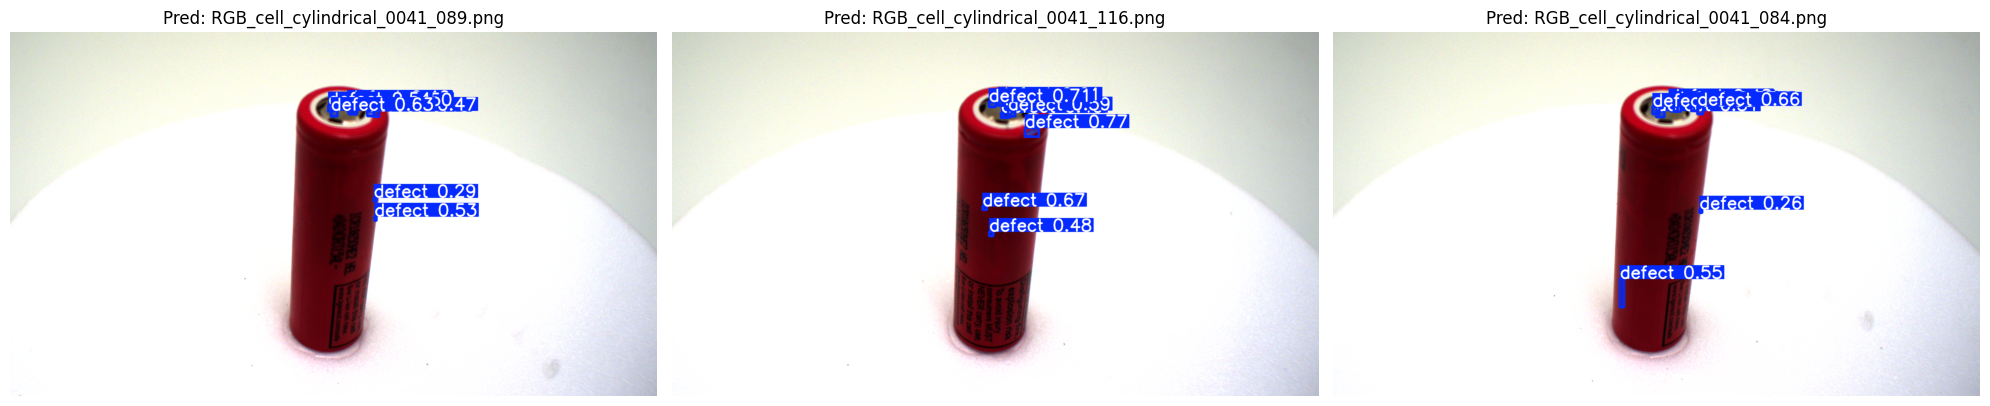

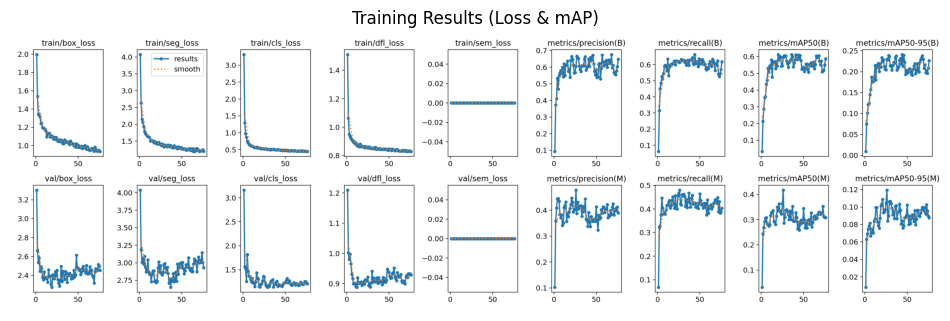

In [ ]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# 1. 경로 정의 (에러 방지를 위해 명시적으로 재설정)
PROJECT_DIR = "/content/runs"
EXP_NAME = "yolo11l_exterior_defect_v1"
RESULT_DIR = os.path.join(PROJECT_DIR, EXP_NAME)
WEIGHTS_PATH = os.path.join(RESULT_DIR, "weights/best.pt")

# 2. 가중치 파일 존재 여부 확인
if not os.path.exists(WEIGHTS_PATH):
    print(f"❌ 오류: 학습 결과 파일을 찾을 수 없습니다. 경로를 확인해주세요: {WEIGHTS_PATH}")
else:
    # 3. 모델 로드
    best_model = YOLO(WEIGHTS_PATH)

    # 4. 검증 데이터 경로 설정
    VAL_IMG_DIR = "/content/yolo_seg_dataset/images/val"

    # 5. 랜덤 샘플 추출 및 예측
    if os.path.exists(VAL_IMG_DIR):
        val_images = [f for f in os.listdir(VAL_IMG_DIR) if f.endswith(('.png', '.jpg', '.jpeg'))]

        if len(val_images) > 0:
            sample_images = random.sample(val_images, min(3, len(val_images))) # 최대 3개 확인

            fig, axes = plt.subplots(1, len(sample_images), figsize=(20, 10))
            if len(sample_images) == 1: axes = [axes] # 샘플이 1개일 때 대비

            for i, img_name in enumerate(sample_images):
                img_path = os.path.join(VAL_IMG_DIR, img_name)

                # 예측 실행 (retina_masks=True로 정밀도 유지)
                results = best_model.predict(img_path, conf=0.25, retina_masks=True)[0]

                # 결과 렌더링
                res_plotted = results.plot(labels=True, boxes=True, masks=True)
                res_plotted = cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB)

                axes[i].imshow(res_plotted)
                axes[i].set_title(f"Pred: {img_name}")
                axes[i].axis('off')

            plt.tight_layout()
            plt.show()
        else:
            print("❌ 오류: 검증 폴더에 이미지 파일이 없습니다.")
    else:
        print(f"❌ 오류: 검증 이미지 경로가 존재하지 않습니다: {VAL_IMG_DIR}")

# 6. 학습 결과 차트(results.png) 출력
results_png = os.path.join(RESULT_DIR, "results.png")
if os.path.exists(results_png):
    plt.figure(figsize=(12, 8))
    img = cv2.imread(results_png)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title("Training Results (Loss & mAP)")
    plt.axis('off')
    plt.show()

단일 이미지 시각화 결과 확인


image 1/1 /content/yolo_seg_dataset/images/val/RGB_cell_cylindrical_0041_054.png: 288x512 4 defects, 86.1ms
Speed: 1.5ms preprocess, 86.1ms inference, 2.4ms postprocess per image at shape (1, 3, 288, 512)


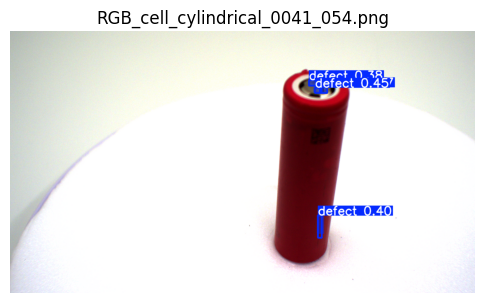

In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import os
import random

# 🔁 m-seg 모델 로드
model = YOLO("/content/runs/yolov8m_seg_exterior_defect/weights/best.pt")

# val 이미지 하나 랜덤 선택
VAL_IMG_DIR = "/content/yolo_seg_dataset/images/val"
img_name = random.choice(os.listdir(VAL_IMG_DIR))
img_path = os.path.join(VAL_IMG_DIR, img_name)

# 추론
result = model(img_path, conf=0.25)[0]

# YOLO plot 결과 (BGR → RGB)
vis_img = result.plot()
vis_img = cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB)

# 시각화
plt.figure(figsize=(6, 6))
plt.title(img_name)
plt.imshow(vis_img)
plt.axis("off")
plt.show()


In [ ]:
import os
import json
from collections import Counter
from tqdm import tqdm

LBL_DIR = "/content/dataset/Sample/02.라벨링데이터/Exterior_Img_Datasets/label"
json_files = [f for f in os.listdir(LBL_DIR) if f.endswith('.json')]

all_labels = []

for js in tqdm(json_files):
    with open(os.path.join(LBL_DIR, js), "r", encoding="utf-8") as f:
        data = json.load(f)
        # AI Hub 데이터 구조에 따라 'defects' 또는 'annotations' 내부를 확인해야 합니다.
        # 아래는 'defects' 리스트 안에 'label' 키가 있다고 가정할 때의 코드입니다.
        for defect in data.get("defects", []):
            label_name = defect.get("label") or defect.get("category") # 키값은 데이터셋마다 다를 수 있음
            all_labels.append(label_name)

# 클래스별 개수 출력
label_counts = Counter(all_labels)
print("\n--- [ 데이터셋 클래스 분포 현황 ] ---")
for label, count in label_counts.items():
    print(f"클래스명: {label} | 개수: {count}개")

100%|██████████| 632/632 [00:00<00:00, 4956.68it/s]


--- [ 데이터셋 클래스 분포 현황 ] ---
클래스명: None | 개수: 6485개



image 1/1 /content/yolo_seg_dataset/images/val/RGB_cell_cylindrical_0041_041.png: 288x512 5 defects, 10.8ms
Speed: 1.5ms preprocess, 10.8ms inference, 2.2ms postprocess per image at shape (1, 3, 288, 512)


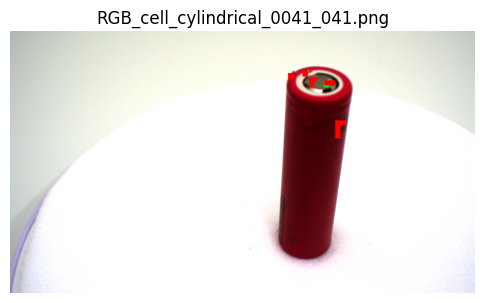


image 1/1 /content/yolo_seg_dataset/images/val/RGB_cell_cylindrical_0041_100.png: 288x512 3 defects, 11.0ms
Speed: 1.5ms preprocess, 11.0ms inference, 2.1ms postprocess per image at shape (1, 3, 288, 512)


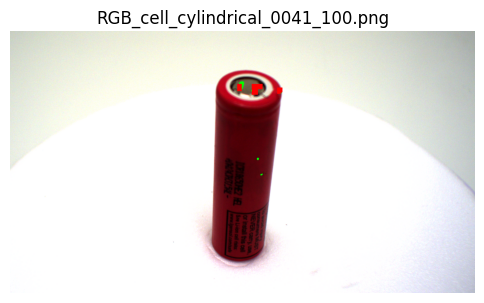


image 1/1 /content/yolo_seg_dataset/images/val/RGB_cell_cylindrical_0041_124.png: 288x512 4 defects, 11.3ms
Speed: 1.6ms preprocess, 11.3ms inference, 2.3ms postprocess per image at shape (1, 3, 288, 512)


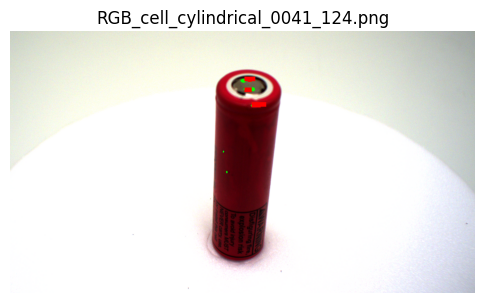


image 1/1 /content/yolo_seg_dataset/images/val/RGB_cell_cylindrical_0041_133.png: 288x512 4 defects, 11.1ms
Speed: 1.6ms preprocess, 11.1ms inference, 2.3ms postprocess per image at shape (1, 3, 288, 512)


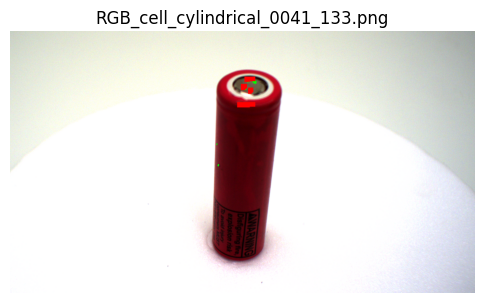


image 1/1 /content/yolo_seg_dataset/images/val/RGB_cell_cylindrical_0041_121.png: 288x512 3 defects, 11.0ms
Speed: 1.6ms preprocess, 11.0ms inference, 2.4ms postprocess per image at shape (1, 3, 288, 512)


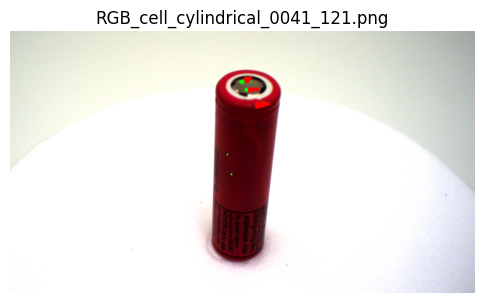


image 1/1 /content/yolo_seg_dataset/images/val/RGB_cell_cylindrical_0041_036.png: 288x512 5 defects, 11.2ms
Speed: 1.5ms preprocess, 11.2ms inference, 2.3ms postprocess per image at shape (1, 3, 288, 512)


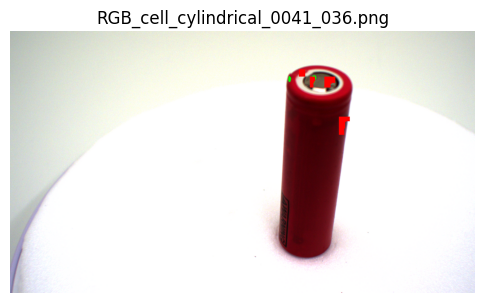


image 1/1 /content/yolo_seg_dataset/images/val/RGB_cell_cylindrical_0041_140.png: 288x512 4 defects, 11.3ms
Speed: 1.6ms preprocess, 11.3ms inference, 2.3ms postprocess per image at shape (1, 3, 288, 512)


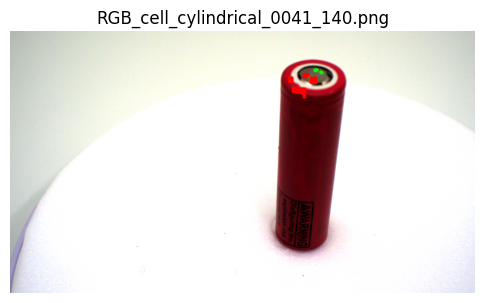


image 1/1 /content/yolo_seg_dataset/images/val/RGB_cell_cylindrical_0041_135.png: 288x512 5 defects, 11.2ms
Speed: 1.5ms preprocess, 11.2ms inference, 2.3ms postprocess per image at shape (1, 3, 288, 512)


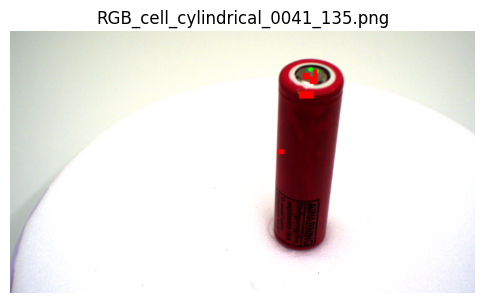


image 1/1 /content/yolo_seg_dataset/images/val/RGB_cell_cylindrical_0041_155.png: 288x512 3 defects, 11.9ms
Speed: 1.6ms preprocess, 11.9ms inference, 2.3ms postprocess per image at shape (1, 3, 288, 512)


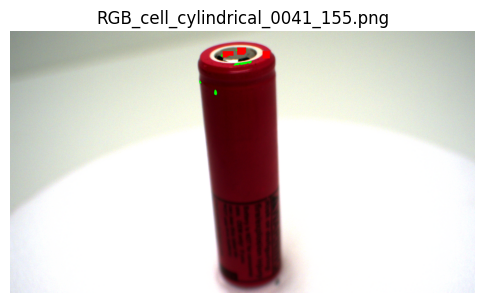


image 1/1 /content/yolo_seg_dataset/images/val/RGB_cell_cylindrical_0041_030.png: 288x512 4 defects, 11.0ms
Speed: 1.5ms preprocess, 11.0ms inference, 2.1ms postprocess per image at shape (1, 3, 288, 512)


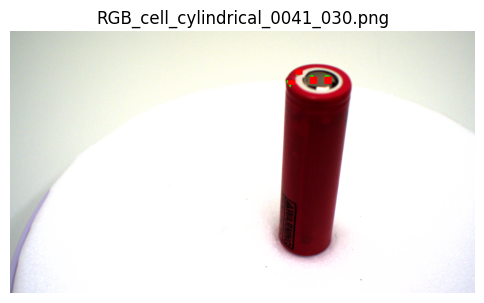

In [ ]:
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import random
from ultralytics import YOLO

# -----------------------------
# 설정
# -----------------------------
MODEL_PATH = "/content/runs/yolov8m_seg_exterior_defect/weights/best.pt"
IMG_DIR = "/content/yolo_seg_dataset/images/val"
GT_JSON_DIR = "/content/dataset/Sample/02.라벨링데이터/Exterior_Img_Datasets/label"

NUM_SAMPLES = 10  # 비교할 이미지 수

model = YOLO(MODEL_PATH)

# -----------------------------
# GT mask 로드
# -----------------------------
def load_gt_mask(img_path):
    img = cv2.imread(img_path)
    h, w, _ = img.shape
    mask = np.zeros((h, w), dtype=np.uint8)

    json_name = os.path.basename(img_path).replace(".png", ".json")
    json_path = os.path.join(GT_JSON_DIR, json_name)

    if not os.path.exists(json_path):
        return mask.astype(bool)

    with open(json_path, "r") as f:
        data = json.load(f)

    for defect in data.get("defects", []):
        pts = defect["points"]
        polygon = np.array(
            [[int(pts[i]), int(pts[i+1])] for i in range(0, len(pts), 2)],
            dtype=np.int32
        )
        cv2.fillPoly(mask, [polygon], 1)

    return mask.astype(bool)

# -----------------------------
# 비교 시각화
# -----------------------------
sample_imgs = random.sample(os.listdir(IMG_DIR), NUM_SAMPLES)

for img_name in sample_imgs:
    img_path = os.path.join(IMG_DIR, img_name)

    # 원본 이미지
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    H, W = img_rgb.shape[:2]

    # GT
    gt_mask = load_gt_mask(img_path)

    # YOLO 예측
    result = model(img_path, conf=0.25)[0]

    pred_mask = np.zeros((H, W), dtype=bool)
    if result.masks is not None:
        for m in result.masks.data:
            m = m.cpu().numpy().astype(np.uint8)
            m = cv2.resize(m, (W, H), interpolation=cv2.INTER_NEAREST)
            pred_mask |= m.astype(bool)

    # -----------------------------
    # 시각화
    # -----------------------------
    overlay = img_rgb.copy()

    # GT: 초록
    overlay[gt_mask] = [0, 255, 0]

    # Prediction: 빨강
    overlay[pred_mask] = [255, 0, 0]

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.title(img_name)
    plt.axis("off")
    plt.show()


In [ ]:
import os
import cv2
import json
import numpy as np
import torch
from ultralytics import YOLO
from tqdm import tqdm

# -----------------------------
# 1. 경로 & 모델 설정 (YOLO11l)
# -----------------------------
MODEL_PATH = "/content/runs/yolo11l_exterior_defect_v1/weights/best.pt"
model = YOLO(MODEL_PATH)

IMG_DIR = "/content/yolo_seg_dataset/images/val"
# GT JSON은 원본 데이터 경로를 참조합니다.
JSON_GT_DIR = "/content/dataset/Sample/02.라벨링데이터/Exterior_Img_Datasets/label"

# -----------------------------
# 2. Metric 함수 (수식 기반)
# -----------------------------
def compute_iou(pred, gt):
    intersection = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    if union == 0:
        return 1.0 if gt.sum() == 0 else 0.0
    return intersection / union

def compute_dice(pred, gt):
    intersection = np.logical_and(pred, gt).sum()
    denom = pred.sum() + gt.sum()
    if denom == 0:
        return 1.0
    return (2. * intersection) / denom

# -----------------------------
# 3. GT Mask 생성 (JSON -> Binary Mask)
# -----------------------------
def load_gt_mask(img_path):
    img = cv2.imread(img_path)
    h, w, _ = img.shape
    mask = np.zeros((h, w), dtype=np.uint8)

    json_name = os.path.basename(img_path).replace(".png", ".json")
    json_path = os.path.join(JSON_GT_DIR, json_name)

    if not os.path.exists(json_path):
        return mask.astype(bool)

    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    for defect in data.get("defects", []):
        pts = defect["points"]
        # [x, y, x, y...] 구조를 [[x, y], [x, y]...]로 변환
        polygon = np.array(
            [[int(pts[i]), int(pts[i+1])] for i in range(0, len(pts), 2)],
            dtype=np.int32
        )
        cv2.fillPoly(mask, [polygon], 1)

    return mask.astype(bool)

# -----------------------------
# 4. 전체 Validation Set 평가 실행
# -----------------------------
ious = []
dices = []
image_files = [f for f in os.listdir(IMG_DIR) if f.endswith(('.png', '.jpg'))]

print(f"🚀 YOLO11l-seg 평가 시작 (총 {len(image_files)}장)")

for img_name in tqdm(image_files):
    img_path = os.path.join(IMG_DIR, img_name)

    # Ground Truth 로드
    gt_mask = load_gt_mask(img_path)

    # 모델 추론 (retina_masks=True로 픽셀 손실 최소화)
    result = model.predict(img_path, conf=0.25, retina_masks=True, verbose=False)[0]

    pred_mask = np.zeros_like(gt_mask, dtype=bool)

    if result.masks is not None:
        # result.masks.data는 (N, H, W) 형태의 텐서입니다.
        for m in result.masks.data:
            m_np = m.cpu().numpy().astype(np.uint8)

            # 예측 마스크 해상도를 원본(GT) 크기에 맞게 조정
            if m_np.shape[:2] != gt_mask.shape:
                m_resized = cv2.resize(
                    m_np,
                    (gt_mask.shape[1], gt_mask.shape[0]),
                    interpolation=cv2.INTER_NEAREST
                ).astype(bool)
            else:
                m_resized = m_np.astype(bool)

            pred_mask |= m_resized

    # 성능 기록
    ious.append(compute_iou(pred_mask, gt_mask))
    dices.append(compute_dice(pred_mask, gt_mask))

# -----------------------------
# 5. 최종 결과 출력
# -----------------------------
print("\n" + "="*30)
print(f"📊 YOLO11l-seg Final Results")
print(f"  - mIoU : {np.mean(ious):.4f}")
print(f"  - Dice : {np.mean(dices):.4f}")
print("="*30)

🚀 YOLO11l-seg 평가 시작 (총 127장)


100%|██████████| 127/127 [00:15<00:00,  8.17it/s]


📊 YOLO11l-seg Final Results
  - mIoU : 0.5571
  - Dice : 0.7090



image 1/1 /content/yolo_seg_dataset/images/val/RGB_cell_cylindrical_0041_094.png: 288x512 2 defects, 33.9ms
Speed: 2.2ms preprocess, 33.9ms inference, 7.6ms postprocess per image at shape (1, 3, 288, 512)


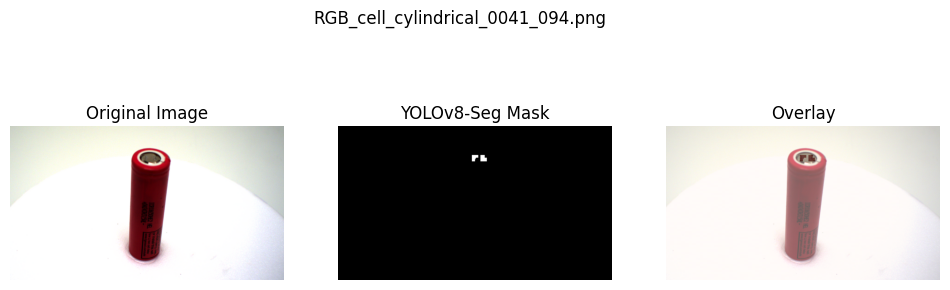

In [ ]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import numpy as np

# 모델 로드
model = YOLO("/content/runs/yolov8_seg_exterior_defect/weights/best.pt")

# val 이미지 랜덤 선택
VAL_IMG_DIR = "/content/yolo_seg_dataset/images/val"
img_name = random.choice(os.listdir(VAL_IMG_DIR))
img_path = os.path.join(VAL_IMG_DIR, img_name)

# 추론
result = model(img_path, conf=0.25)[0]

# 원본 이미지
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# YOLO mask 결합
pred_mask = np.zeros(img.shape[:2], dtype=bool)
if result.masks is not None:
    for m in result.masks.data:
        m_np = m.cpu().numpy().astype(np.uint8)
        m_resized = cv2.resize(
            m_np,
            (img.shape[1], img.shape[0]),
            interpolation=cv2.INTER_NEAREST
        ).astype(bool)
        pred_mask |= m_resized

# 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("YOLOv8-Seg Mask")
plt.imshow(pred_mask, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Overlay")
plt.imshow(img)
plt.imshow(pred_mask, alpha=0.4, cmap="Reds")
plt.axis("off")

plt.suptitle(img_name)
plt.show()


In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git


  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-bsl7qs4p
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-bsl7qs4p
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=adf8c652b9c5ff886b4c321a44dcc43f5b10ca647dbd49f9ad88ce8dad069854
  Stored in directory: /tmp/pip-ephem-wheel-cache-3y3zzeag/wheels/29/82/ff/04e2be9805a1cb48bec0b85b5a6da6b63f647645750a0e42d4
Successfully built segment_anything


In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -O /content/sam_vit_h_4b8939.pth


--2026-01-19 05:45:39--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.239.50.104, 18.239.50.18, 18.239.50.120, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.239.50.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘/content/sam_vit_h_4b8939.pth’

/content/sam_vit_h_ 100%[===================>]   2.39G   246MB/s    in 14s     

2026-01-19 05:45:53 (175 MB/s) - ‘/content/sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [ ]:
import torch
from segment_anything import sam_model_registry, SamPredictor

SAM_CKPT = "/content/sam_vit_h_4b8939.pth"  # 미리 다운로드해둔 weight
MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint=SAM_CKPT)
sam.to("cuda")
predictor = SamPredictor(sam)



image 1/1 /content/yolo_seg_dataset/images/val/RGB_cell_cylindrical_0041_066.png: 288x512 5 defects, 17.5ms
Speed: 3.3ms preprocess, 17.5ms inference, 9.8ms postprocess per image at shape (1, 3, 288, 512)


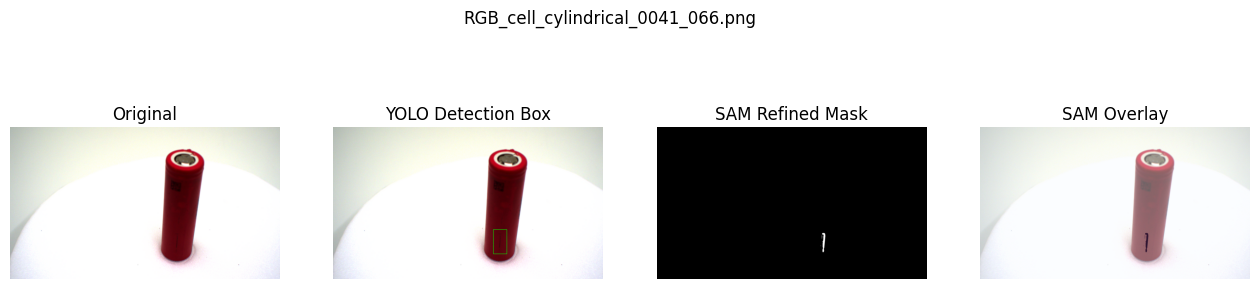

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# -----------------------------
# 0. 모델 / predictor는 이미 로드되어 있다고 가정
# model = YOLO(...)
# predictor = SamPredictor(...)
# -----------------------------

# -----------------------------
# 1. val 이미지 하나 선택
# -----------------------------
VAL_IMG_DIR = "/content/yolo_seg_dataset/images/val"
img_name = random.choice(os.listdir(VAL_IMG_DIR))
img_path = os.path.join(VAL_IMG_DIR, img_name)

# 원본 이미지
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
H, W = img_rgb.shape[:2]

# -----------------------------
# 2. YOLO 추론
# -----------------------------
result = model(img_path, conf=0.25)[0]

# -----------------------------
# 3. YOLO detection BOX 사용 (⭐ 핵심 수정 부분)
# -----------------------------
if result.boxes is None or len(result.boxes) == 0:
    print("❌ YOLO did not detect any box")
else:
    # 첫 번째 detection box 사용 (단일 클래스 가정)
    box = result.boxes.xyxy[0].cpu().numpy()  # (x1, y1, x2, y2)

    # padding (작은 defect 대비, 매우 중요)
    pad = 40
    x1, y1, x2, y2 = box
    x1 = max(0, int(x1 - pad))
    y1 = max(0, int(y1 - pad))
    x2 = min(W, int(x2 + pad))
    y2 = min(H, int(y2 + pad))

    sam_box = np.array([x1, y1, x2, y2])

    # -----------------------------
    # 4. SAM refinement
    # -----------------------------
    predictor.set_image(img_rgb)

    masks, scores, _ = predictor.predict(
        box=sam_box[None, :],
        multimask_output=False
    )

    sam_mask = masks[0]  # (H, W), bool

    # -----------------------------
    # 5. YOLO box 시각화용 (선택)
    # -----------------------------
    yolo_box_vis = img_rgb.copy()
    cv2.rectangle(
        yolo_box_vis,
        (x1, y1),
        (x2, y2),
        (0, 255, 0),
        2
    )

    # -----------------------------
    # 6. 시각화 (전 / 후 비교)
    # -----------------------------
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 4, 1)
    plt.title("Original")
    plt.imshow(img_rgb)
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.title("YOLO Detection Box")
    plt.imshow(yolo_box_vis)
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.title("SAM Refined Mask")
    plt.imshow(sam_mask, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.title("SAM Overlay")
    plt.imshow(img_rgb)
    plt.imshow(sam_mask, alpha=0.4, cmap="Blues")
    plt.axis("off")

    plt.suptitle(img_name)
    plt.show()


In [ ]:
import os
import cv2
import json
import numpy as np
from ultralytics import YOLO

# --------------------------------
# 경로
# --------------------------------
IMG_DIR = "/content/yolo_seg_dataset/images/val"
JSON_GT_DIR = "/content/dataset/Sample/02.라벨링데이터/Exterior_Img_Datasets/label"

# --------------------------------
# Metric 함수
# --------------------------------
def compute_iou(pred, gt):
    inter = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    if union == 0:
        return 1.0 if gt.sum() == 0 else 0.0
    return inter / union

def compute_dice(pred, gt):
    inter = np.logical_and(pred, gt).sum()
    denom = pred.sum() + gt.sum()
    if denom == 0:
        return 1.0
    return 2 * inter / denom

# --------------------------------
# GT mask 로드
# --------------------------------
def load_gt_mask(img_path):
    img = cv2.imread(img_path)
    h, w, _ = img.shape
    mask = np.zeros((h, w), dtype=np.uint8)

    json_name = os.path.basename(img_path).replace(".png", ".json")
    json_path = os.path.join(JSON_GT_DIR, json_name)

    if not os.path.exists(json_path):
        return mask.astype(bool)

    with open(json_path, "r") as f:
        data = json.load(f)

    for defect in data.get("defects", []):
        pts = defect["points"]
        polygon = np.array(
            [[int(pts[i]), int(pts[i+1])] for i in range(0, len(pts), 2)],
            dtype=np.int32
        )
        cv2.fillPoly(mask, [polygon], 1)

    return mask.astype(bool)

# --------------------------------
# YOLO BOX → SAM mask 생성
# --------------------------------
def get_sam_mask_from_yolo_box(img_path, result, predictor, pad=40):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    H, W = img_rgb.shape[:2]

    if result.boxes is None or len(result.boxes) == 0:
        return np.zeros((H, W), dtype=bool)

    # 첫 번째 YOLO detection box
    box = result.boxes.xyxy[0].cpu().numpy()
    x1, y1, x2, y2 = box

    # padding
    x1 = max(0, int(x1 - pad))
    y1 = max(0, int(y1 - pad))
    x2 = min(W, int(x2 + pad))
    y2 = min(H, int(y2 + pad))

    sam_box = np.array([x1, y1, x2, y2])

    predictor.set_image(img_rgb)

    masks, scores, _ = predictor.predict(
        box=sam_box[None, :],
        multimask_output=False
    )

    return masks[0].astype(bool)

# --------------------------------
# 전체 val set 평가
# --------------------------------
ious = []
dices = []

for img_name in os.listdir(IMG_DIR):
    img_path = os.path.join(IMG_DIR, img_name)

    # GT
    gt_mask = load_gt_mask(img_path)

    # YOLO prediction
    result = model(img_path, conf=0.25)[0]

    # YOLO BOX + SAM mask
    pred_mask = get_sam_mask_from_yolo_box(
        img_path,
        result,
        predictor,
        pad=40
    )

    # metric
    ious.append(compute_iou(pred_mask, gt_mask))
    dices.append(compute_dice(pred_mask, gt_mask))

print(f"[YOLO + SAM] mIoU : {np.mean(ious):.4f}")
print(f"[YOLO + SAM] Dice : {np.mean(dices):.4f}")



image 1/1 /content/yolo_seg_dataset/images/val/RGB_cell_cylindrical_0041_170.png: 288x512 2 defects, 11.2ms
Speed: 1.7ms preprocess, 11.2ms inference, 2.4ms postprocess per image at shape (1, 3, 288, 512)

image 1/1 /content/yolo_seg_dataset/images/val/RGB_cell_cylindrical_0041_114.png: 288x512 5 defects, 8.3ms
Speed: 1.4ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 288, 512)

image 1/1 /content/yolo_seg_dataset/images/val/RGB_cell_cylindrical_0041_159.png: 288x512 2 defects, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 288, 512)

image 1/1 /content/yolo_seg_dataset/images/val/RGB_cell_cylindrical_0041_095.png: 288x512 2 defects, 8.0ms
Speed: 1.4ms preprocess, 8.0ms inference, 1.9ms postprocess per image at shape (1, 3, 288, 512)

image 1/1 /content/yolo_seg_dataset/images/val/RGB_cell_cylindrical_0041_030.png: 288x512 2 defects, 9.7ms
Speed: 2.2ms preprocess, 9.7ms inference, 2.5ms postprocess per image at s

In [ ]:
from ultralytics import YOLO
import numpy as np
import cv2

yolo = YOLO("/content/runs/segment/yolov8_seg_exterior_defect/weights/best.pt")

img_path = "/content/yolo_seg_dataset/images/val/샘플이미지.png"
result = yolo(img_path)[0]


FileNotFoundError: [Errno 2] No such file or directory: '/content/runs/segment/yolov8_seg_exterior_defect/weights/best.pt'

In [ ]:
# YOLOv8 mask (H, W)
mask = result.masks.data[0].cpu().numpy()

# bbox 계산
ys, xs = np.where(mask > 0)
x1, x2 = xs.min(), xs.max()
y1, y2 = ys.min(), ys.max()

bbox = np.array([x1, y1, x2, y2])


In [ ]:
# RGB 이미지 로드
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

predictor.set_image(image)

sam_masks, scores, _ = predictor.predict(
    box=bbox[None, :],     # (1, 4)
    multimask_output=True
)

# 가장 score 높은 mask 선택
best_idx = np.argmax(scores)
refined_mask = sam_masks[best_idx]


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("YOLOv8 Mask")
plt.imshow(mask, cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("SAM Refined Mask")
plt.imshow(refined_mask, cmap="gray")
plt.axis("off")

plt.show()


----------------------------------------------

In [ ]:
import json
from pprint import pprint
import os

label_dir = "/content/dataset/Sample/02.라벨링데이터/CT_Datasets/label"

json_files = sorted([f for f in os.listdir(label_dir) if f.endswith(".json")])
print("JSON 개수:", len(json_files))
print("첫 파일:", json_files[0])

with open(os.path.join(label_dir, json_files[0]), "r", encoding="utf-8") as f:
    data = json.load(f)

print("\n[TOP-LEVEL KEYS]")
print(data.keys())


JSON 개수: 732
첫 파일: CT_cell_pouch_101_x_000.json

[TOP-LEVEL KEYS]
dict_keys(['data_info', 'swelling', 'defects', 'image_info'])


In [ ]:
import os, json
from collections import Counter

label_dir = "/content/dataset/Sample/02.라벨링데이터/CT_Datasets/label"

stats = Counter()
examples = {
    "defects_none": None,
    "defects_exists": None
}

for fn in os.listdir(label_dir):
    if not fn.endswith(".json"):
        continue

    with open(os.path.join(label_dir, fn), "r", encoding="utf-8") as f:
        d = json.load(f)

    swelling = d.get("swelling", {}).get("swelling", None)
    defects = d.get("defects")

    if defects is None:
        stats["defects_none"] += 1
        if examples["defects_none"] is None:
            examples["defects_none"] = fn
    elif isinstance(defects, list) and len(defects) > 0:
        stats["defects_exists"] += 1
        if examples["defects_exists"] is None:
            examples["defects_exists"] = fn
    else:
        stats["defects_empty"] += 1

    if swelling is True:
        stats["swelling_true"] += 1
    elif swelling is False:
        stats["swelling_false"] += 1

print("📊 DATASET STATISTICS")
for k, v in stats.items():
    print(f"{k:20s}: {v}")

print("\n📌 Example files")
print("defects=None      :", examples["defects_none"])
print("defects exists    :", examples["defects_exists"])


📊 DATASET STATISTICS
defects_exists      : 279
swelling_false      : 732
defects_none        : 453

📌 Example files
defects=None      : CT_cell_pouch_101_x_135.json
defects exists    : CT_cell_pouch_101_y_086.json


defects 있는 이미지 수: 279


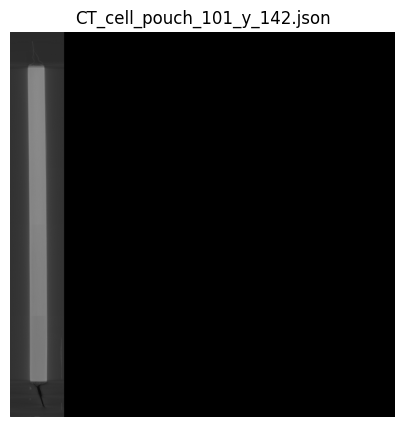

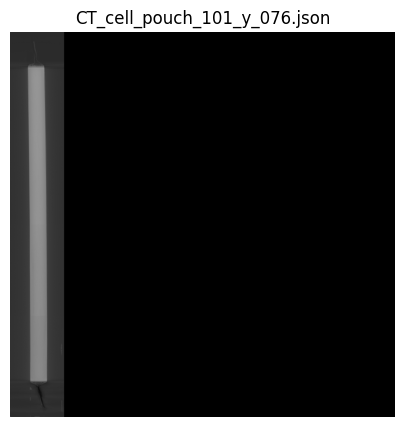

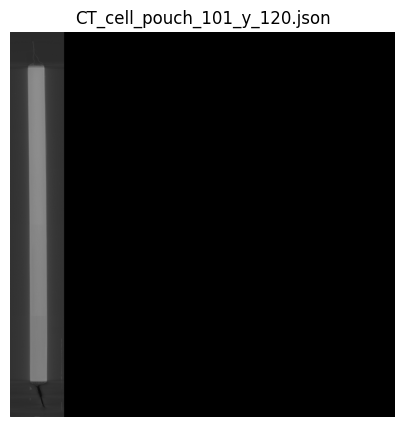

In [ ]:
import os, json, cv2
import matplotlib.pyplot as plt
import random

IMG_DIR = "/content/dataset/Sample/01.원천데이터/CT_Datasets/images"
LBL_DIR = "/content/dataset/Sample/02.라벨링데이터/CT_Datasets/label"

# defects 있는 파일만 수집
files = []
for fn in os.listdir(LBL_DIR):
    if not fn.endswith(".json"):
        continue
    with open(os.path.join(LBL_DIR, fn), "r", encoding="utf-8") as f:
        d = json.load(f)
    if isinstance(d.get("defects"), list) and len(d["defects"]) > 0:
        files.append(fn)

print("defects 있는 이미지 수:", len(files))

# 랜덤 3장 시각화
sample_files = random.sample(files, 3)

for fn in sample_files:
    img_path = os.path.join(IMG_DIR, fn.replace(".json", ".jpg"))
    lbl_path = os.path.join(LBL_DIR, fn)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    with open(lbl_path, "r", encoding="utf-8") as f:
        d = json.load(f)

    for defect in d["defects"]:
        poly = defect.get("polygon")
        if poly is None:
            continue
        pts = [(int(poly[i]), int(poly[i+1])) for i in range(0, len(poly), 2)]
        for i in range(len(pts)):
            cv2.line(img, pts[i], pts[(i+1) % len(pts)], (255, 0, 0), 2)

    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.title(fn)
    plt.axis("off")
    plt.show()


In [ ]:
import numpy as np

for defect in d["defects"]:
    poly = defect["polygon"]
    xs = poly[0::2]
    ys = poly[1::2]

    x1, x2 = int(min(xs)), int(max(xs))
    y1, y2 = int(min(ys)), int(max(ys))

    pad = 20
    crop = img[max(0,y1-pad):min(img.shape[0],y2+pad),
               max(0,x1-pad):min(img.shape[1],x2+pad)]

    plt.figure(figsize=(4,4))
    plt.imshow(crop)
    plt.title("Defect crop")
    plt.axis("off")
    plt.show()


KeyError: 'polygon'

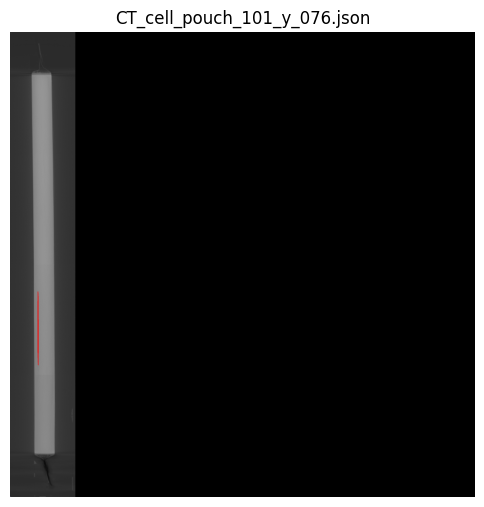

In [ ]:
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np

# 경로 설정
img_path = "/content/dataset/Sample/01.원천데이터/CT_Datasets/images/CT_cell_pouch_101_y_076.jpg"
json_path = "/content/dataset/Sample/02.라벨링데이터/CT_Datasets/label/CT_cell_pouch_101_y_076.json"

# 이미지 로드
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# JSON 로드
with open(json_path, "r") as f:
    d = json.load(f)

# 시각화용 복사본
vis = img.copy()

# defects가 있는 경우만
if d["defects"] is not None:
    for defect in d["defects"]:
        pts = defect["points"]

        # (N, 2) 형태로 변환
        poly = np.array(pts, dtype=np.int32).reshape(-1, 2)

        # polygon 채우기
        cv2.polylines(vis, [poly], isClosed=True, color=(255, 0, 0), thickness=3)
        cv2.fillPoly(vis, [poly], color=(255, 0, 0))

# 시각화
plt.figure(figsize=(6, 12))
plt.imshow(vis)
plt.title(json_path.split("/")[-1])
plt.axis("off")
plt.show()


In [ ]:
import json
import os
import cv2
import numpy as np
from tqdm import tqdm

# ===============================
# 경로 설정
# ===============================
IMG_DIR = "/content/dataset/Sample/01.원천데이터/CT_Datasets/images"
JSON_DIR = "/content/dataset/Sample/02.라벨링데이터/CT_Datasets/label"
OUT_LABEL_DIR = "/content/battery_yolo/labels/all"

os.makedirs(OUT_LABEL_DIR, exist_ok=True)

# ===============================
# JSON 목록
# ===============================
json_files = sorted([f for f in os.listdir(JSON_DIR) if f.endswith(".json")])

print("총 JSON 개수:", len(json_files))

# ===============================
# 변환 시작
# ===============================
for jf in tqdm(json_files):
    json_path = os.path.join(JSON_DIR, jf)

    with open(json_path, "r") as f:
        data = json.load(f)

    base = jf.replace(".json", "")
    img_path = os.path.join(IMG_DIR, base + ".jpg")
    label_path = os.path.join(OUT_LABEL_DIR, base + ".txt")

    # 이미지가 없으면 스킵
    if not os.path.exists(img_path):
        continue

    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    lines = []

    # defects 없는 경우 → 빈 txt
    if data["defects"] is not None:
        for defect in data["defects"]:
            if "points" not in defect:
                continue

            pts = np.array(defect["points"], dtype=np.float32).reshape(-1, 2)

            # 정규화 (0~1)
            pts[:, 0] /= w
            pts[:, 1] /= h

            # YOLO 형식 문자열
            coords = " ".join([f"{x:.6f} {y:.6f}" for x, y in pts])
            line = f"0 {coords}"
            lines.append(line)

    # txt 저장
    with open(label_path, "w") as f:
        f.write("\n".join(lines))

print("YOLOv8-seg 라벨 변환 완료")


총 JSON 개수: 732


100%|██████████| 732/732 [01:13<00:00,  9.93it/s]

YOLOv8-seg 라벨 변환 완료


In [ ]:
# 샘플 하나 확인
!head /content/battery_yolo/labels/all/CT_cell_pouch_101_y_086.txt


0 0.060047 0.558360 0.059825 0.597850 0.059950 0.695400 0.060530 0.732010 0.060795 0.677225 0.060697 0.571670

In [ ]:
  import os
  import shutil
  import random
  from pathlib import Path

  # 1. 경로 설정 (확인된 폴더 구조 반영)
  source_img_dir = Path("dataset/Sample/01.원천데이터/CT_Datasets/images")
  source_lbl_dir = Path("dataset/Sample/02.라벨링데이터/CT_Datasets/label") # 'label' 폴더 추가

  target_root = Path("battery_dataset")

  # 2. 대상 디렉토리 생성
  for split in ['train', 'val']:
      (target_root / 'images' / split).mkdir(parents=True, exist_ok=True)
      (target_root / 'labels' / split).mkdir(parents=True, exist_ok=True)

  # 3. 데이터 쌍 매칭
  image_files = list(source_img_dir.glob("*.jpg"))
  data_pairs = []

  for img_path in image_files:
      # 이미지 파일명과 동일한 이름의 .json 라벨 확인
      # 만약 라벨 확장자가 .json이 아니라면 아래 ".json"을 수정하세요.
      label_path = source_lbl_dir / f"{img_path.stem}.json"

      if label_path.exists():
          data_pairs.append((img_path, label_path))

  # 4. 데이터 분할 및 복사 (8:2)
  if not data_pairs:
      print(f"매칭 실패! 라벨 폴더({source_lbl_dir}) 내 파일의 확장자를 확인해주세요.")
      # 실제 파일 확장자 확인을 위해 하나만 출력
      sample_labels = list(source_lbl_dir.glob("*"))
      if sample_labels:
          print(f"라벨 폴더 내 실제 파일 예시: {sample_labels[0].name}")
  else:
      print(f"총 {len(data_pairs)}개의 매칭된 쌍을 찾았습니다. 복사를 시작합니다...")

      random.seed(42)
      random.shuffle(data_pairs)
      split_idx = int(len(data_pairs) * 0.8)

      splits = {
          'train': data_pairs[:split_idx],
          'val': data_pairs[split_idx:]
      }

      for split_name, pairs in splits.items():
          for img_p, lbl_p in pairs:
              shutil.copy(img_p, target_root / 'images' / split_name / img_p.name)
              shutil.copy(lbl_p, target_root / 'labels' / split_name / lbl_p.name)
          print(f" - {split_name} 완료: {len(pairs)}쌍")

      print(f"\n✅ 모든 작업이 완료되었습니다! 경로: {target_root.absolute()}")

총 732개의 매칭된 쌍을 찾았습니다. 복사를 시작합니다...
 - train 완료: 585쌍
 - val 완료: 147쌍

✅ 모든 작업이 완료되었습니다! 경로: /content/battery_dataset


In [ ]:
import json
from pathlib import Path
from tqdm import tqdm

def create_sam3_json(img_split_dir, label_split_dir, output_json, concept="battery defect"):
    coco = {
        "images": [],
        "annotations": [],
        "categories": [{"id": 1, "name": concept}]
    }

    # 이미지가 있는 파일들만 대상으로 정렬
    image_paths = sorted(list(Path(img_split_dir).glob("*.jpg")))
    ann_id = 1

    for i, img_path in enumerate(tqdm(image_paths, desc=f"Converting {output_json}")):
        img_id = i + 1
        label_path = Path(label_split_dir) / f"{img_path.stem}.json"

        if not label_path.exists(): continue

        with open(label_path, 'r', encoding='utf-8') as f:
            raw_data = json.load(f)

        # 이미지 정보 추가
        coco["images"].append({
            "id": img_id,
            "file_name": img_path.name,
            "width": 1920, # 실제 이미지 크기에 맞게 수정 필요
            "height": 1080
        })

        # 어노테이션 정보 추가 (AI-Hub 데이터 키값에 맞춰 수정)
        for obj in raw_data.get('annotations', []):
            poly = obj.get('polygon', [])
            coco["annotations"].append({
                "id": ann_id,
                "image_id": img_id,
                "category_id": 1,
                "segmentation": [poly],
                "bbox": obj.get('bbox', []),
                "area": obj.get('area', 0),
                "iscrowd": 0,
                "noun_phrase": concept # SAM 3 핵심 필드
            })
            ann_id += 1

    with open(output_json, 'w', encoding='utf-8') as f:
        json.dump(coco, f, ensure_ascii=False)

# 기존에 나눈 폴더를 대상으로 통합 JSON 생성
Path("/content/battery_dataset/annotations").mkdir(exist_ok=True)
create_sam3_json("/content/battery_dataset/images/train", "/content/battery_dataset/labels/train", "/content/battery_dataset/annotations/train.json")
create_sam3_json("/content/battery_dataset/images/val", "/content/battery_dataset/labels/val", "/content/battery_dataset/annotations/val.json")

Converting /content/battery_dataset/annotations/train.json: 100%|██████████| 585/585 [00:00<00:00, 9605.28it/s]
Converting /content/battery_dataset/annotations/val.json: 100%|██████████| 147/147 [00:00<00:00, 9436.08it/s]


In [ ]:
%%writefile battery_config.yaml
# 데이터셋 루트 경로
path: /content/battery_dataset
# 이미지 경로 (path 기준 상대 경로)
train: images/train
val: images/val
# SAM 학습용 통합 JSON 경로
ann_train: annotations/train.json
ann_val: annotations/val.json

# 클래스 번호와 이름
names:
  0: battery_defect

Writing battery_config.yaml


In [ ]:
!cd /content
!git clone https://github.com/facebookresearch/segment-anything-2.git
!cd segment-anything-2


Cloning into 'segment-anything-2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 128.11 MiB | 20.57 MiB/s, done.
Resolving deltas: 100% (381/381), done.


In [ ]:
!pip install -e .
!pip install pycocotools opencv-python matplotlib

Obtaining file:///content
ERROR: file:///content does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [ ]:
!mkdir -p checkpoints
!wget https://dl.fbaipublicfiles.com/segment_anything_2/sam2_hiera_base.pt \
  -O checkpoints/sam2_hiera_base.pt


--2026-01-19 00:58:40--  https://dl.fbaipublicfiles.com/segment_anything_2/sam2_hiera_base.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.155.173.80, 18.155.173.40, 18.155.173.116, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.155.173.80|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2026-01-19 00:58:40 ERROR 403: Forbidden.



In [ ]:
!mkdir -p configs


In [ ]:
%%writefile configs/battery_sam2.yaml
model:
  type: sam2_hiera_b
  checkpoint: checkpoints/sam2_hiera_base.pt

dataset:
  train:
    type: coco
    img_dir: /content/battery_dataset/images/train
    ann_file: /content/battery_dataset/annotations/train.json
  val:
    type: coco
    img_dir: /content/battery_dataset/images/val
    ann_file: /content/battery_dataset/annotations/val.json

training:
  epochs: 20
  batch_size: 2
  lr: 1e-4
  weight_decay: 1e-4
  num_workers: 2
  amp: true

output_dir: outputs/battery_sam2


Writing configs/battery_sam2.yaml


In [ ]:
!cd /content/segment-anything-2


In [ ]:
!python scripts/train.py --config configs/battery_sam2.yaml


python3: can't open file '/content/scripts/train.py': [Errno 2] No such file or directory


In [ ]:
!cd /content/segment-anything-2 && ls scripts

ls: cannot access 'scripts': No such file or directory


In [ ]:
!wget https://github.com/JamesQFreeman/SamFineTuner/archive/refs/heads/main.zip -O samfinetuner.zip


--2026-01-19 01:03:08--  https://github.com/JamesQFreeman/SamFineTuner/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2026-01-19 01:03:08 ERROR 404: Not Found.



In [ ]:
!pip install -U ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 27.2 MB/s eta 0:00:00


In [ ]:
%%writefile battery_sam.yaml
path: /content/battery_dataset

train: images/train
val: images/val

names:
  0: battery_defect


Writing battery_sam.yaml


In [ ]:
import json
from pathlib import Path

def coco_to_yolo_seg(coco_json, img_dir, label_out_dir):
    label_out_dir.mkdir(parents=True, exist_ok=True)

    with open(coco_json, "r", encoding="utf-8") as f:
        coco = json.load(f)

    imgs = {img["id"]: img for img in coco["images"]}
    anns_by_img = {}
    for ann in coco["annotations"]:
        anns_by_img.setdefault(ann["image_id"], []).append(ann)

    for img_id, img in imgs.items():
        h, w = img["height"], img["width"]
        anns = anns_by_img.get(img_id, [])
        if not anns:
            continue

        lines = []
        for ann in anns:
            seg = ann["segmentation"][0]  # polygon
            seg_norm = []
            for i in range(0, len(seg), 2):
                seg_norm.append(seg[i] / w)
                seg_norm.append(seg[i+1] / h)

            line = "0 " + " ".join(f"{x:.6f}" for x in seg_norm)
            lines.append(line)

        txt_path = label_out_dir / (Path(img["file_name"]).stem + ".txt")
        with open(txt_path, "w") as f:
            f.write("\n".join(lines))


# 실행
coco_to_yolo_seg(
    "/content/battery_dataset/annotations/train.json",
    "/content/battery_dataset/images/train",
    Path("/content/battery_dataset/labels/train"),
)

coco_to_yolo_seg(
    "/content/battery_dataset/annotations/val.json",
    "/content/battery_dataset/images/val",
    Path("/content/battery_dataset/labels/val"),
)

print("✅ COCO → YOLO segmentation 변환 완료")


✅ COCO → YOLO segmentation 변환 완료


In [ ]:
!ls /content/battery_dataset/images/train | head
!ls /content/battery_dataset/labels/train | head


CT_cell_pouch_101_x_000.jpg
CT_cell_pouch_101_x_001.jpg
CT_cell_pouch_101_x_002.jpg
CT_cell_pouch_101_x_003.jpg
CT_cell_pouch_101_x_004.jpg
CT_cell_pouch_101_x_005.jpg
CT_cell_pouch_101_x_006.jpg
CT_cell_pouch_101_x_007.jpg
CT_cell_pouch_101_x_010.jpg
CT_cell_pouch_101_x_011.jpg
CT_cell_pouch_101_x_000.json
CT_cell_pouch_101_x_001.json
CT_cell_pouch_101_x_002.json
CT_cell_pouch_101_x_003.json
CT_cell_pouch_101_x_004.json
CT_cell_pouch_101_x_005.json
CT_cell_pouch_101_x_006.json
CT_cell_pouch_101_x_007.json
CT_cell_pouch_101_x_010.json
CT_cell_pouch_101_x_011.json


In [ ]:
mkdir -p /content/battery_dataset/yolo_labels/train


In [ ]:
import os, json, glob
import numpy as np
import cv2

IMG_DIR = "/content/battery_dataset/images/train"
JSON_DIR = "/content/battery_dataset/labels/train"
OUT_TXT_DIR = "/content/battery_dataset/yolo_labels/train"
os.makedirs(OUT_TXT_DIR, exist_ok=True)

def flatxy_to_pts(flat_xy):
    return np.array(flat_xy, dtype=np.float32).reshape(-1, 2)

def polygon_to_mask(flat_xy, h, w):
    mask = np.zeros((h, w), dtype=np.uint8)
    pts = flatxy_to_pts(flat_xy).astype(np.int32)
    cv2.fillPoly(mask, [pts], 1)
    return mask

def mask_to_yolo_seg_lines(mask, class_id=0, min_area=500):
    mask_u8 = (mask > 0).astype(np.uint8) * 255
    contours, _ = cv2.findContours(mask_u8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    h, w = mask.shape
    lines = []
    for cnt in contours:
        if cv2.contourArea(cnt) < min_area:
            continue

        cnt = cnt.reshape(-1, 2).astype(np.float32)
        approx = cv2.approxPolyDP(cnt, epsilon=2.0, closed=True).reshape(-1, 2)
        if len(approx) < 3:
            continue

        xs = (approx[:, 0] / w).clip(0, 1)
        ys = (approx[:, 1] / h).clip(0, 1)

        coords = []
        for x, y in zip(xs, ys):
            coords.append(f"{x:.6f}")
            coords.append(f"{y:.6f}")

        lines.append(f"{class_id} " + " ".join(coords))
    return lines

json_paths = sorted(glob.glob(os.path.join(JSON_DIR, "*.json")))
print("json files:", len(json_paths))

for jp in json_paths:
    base = os.path.splitext(os.path.basename(jp))[0]
    img_path = os.path.join(IMG_DIR, base + ".jpg")

    if not os.path.exists(img_path):
        print("missing image:", img_path)
        continue

    with open(jp, "r") as f:
        d = json.load(f)

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    h, w = img.shape[:2]

    outline = d["swelling"]["battery_outline"]
    mask = polygon_to_mask(outline, h, w)

    lines = mask_to_yolo_seg_lines(mask, class_id=0)

    out_txt = os.path.join(OUT_TXT_DIR, base + ".txt")
    with open(out_txt, "w") as f:
        f.write("\n".join(lines))

print("YOLOv8-seg labels created.")


json files: 585
YOLOv8-seg labels created.


In [ ]:
ls /content/battery_dataset/yolo_labels/train | head


CT_cell_pouch_101_x_000.txt
CT_cell_pouch_101_x_001.txt
CT_cell_pouch_101_x_002.txt
CT_cell_pouch_101_x_003.txt
CT_cell_pouch_101_x_004.txt
CT_cell_pouch_101_x_005.txt
CT_cell_pouch_101_x_006.txt
CT_cell_pouch_101_x_007.txt
CT_cell_pouch_101_x_010.txt
CT_cell_pouch_101_x_011.txt


In [ ]:
import os, random, shutil

IMG_SRC = "/content/battery_dataset/images/train"
LBL_SRC = "/content/battery_dataset/yolo_labels/train"

IMG_DST = "/content/battery_yolo/images"
LBL_DST = "/content/battery_yolo/labels"

# 이미지 기준으로 basename 수집
img_bases = sorted([
    os.path.splitext(f)[0]
    for f in os.listdir(IMG_SRC)
    if f.endswith(".jpg")
])

# 해당 이미지에 대응하는 txt만 사용
valid_bases = [
    b for b in img_bases
    if os.path.exists(os.path.join(LBL_SRC, b + ".txt"))
]

print("images:", len(img_bases))
print("valid pairs:", len(valid_bases))

random.seed(42)
random.shuffle(valid_bases)

n = len(valid_bases)
n_train = int(n * 0.8)

train_files = valid_bases[:n_train]
val_files   = valid_bases[n_train:]

for split, split_files in [("train", train_files), ("val", val_files)]:
    for base in split_files:
        shutil.copy(
            os.path.join(IMG_SRC, base + ".jpg"),
            os.path.join(IMG_DST, split, base + ".jpg"),
        )
        shutil.copy(
            os.path.join(LBL_SRC, base + ".txt"),
            os.path.join(LBL_DST, split, base + ".txt"),
        )

print("train:", len(train_files), "val:", len(val_files))


images: 585
valid pairs: 585


FileNotFoundError: [Errno 2] No such file or directory: '/content/battery_yolo/images/train/CT_cell_pouch_101_y_377.jpg'

In [ ]:
!mkdir -p /content/battery_yolo/images/train
!mkdir -p /content/battery_yolo/images/val
!mkdir -p /content/battery_yolo/labels/train
!mkdir -p /content/battery_yolo/labels/val


In [ ]:
import os, random, shutil

IMG_SRC = "/content/battery_dataset/images/train"
LBL_SRC = "/content/battery_dataset/yolo_labels/train"

IMG_DST = "/content/battery_yolo/images"
LBL_DST = "/content/battery_yolo/labels"

# 이미지 기준으로 basename 수집
img_bases = sorted([
    os.path.splitext(f)[0]
    for f in os.listdir(IMG_SRC)
    if f.endswith(".jpg")
])

# 이미지 + 라벨 둘 다 있는 것만
valid_bases = [
    b for b in img_bases
    if os.path.exists(os.path.join(LBL_SRC, b + ".txt"))
]

print("valid pairs:", len(valid_bases))

random.seed(42)
random.shuffle(valid_bases)

n = len(valid_bases)
n_train = int(n * 0.8)

train_files = valid_bases[:n_train]
val_files   = valid_bases[n_train:]

for split, split_files in [("train", train_files), ("val", val_files)]:
    for base in split_files:
        shutil.copy(
            os.path.join(IMG_SRC, base + ".jpg"),
            os.path.join(IMG_DST, split, base + ".jpg"),
        )
        shutil.copy(
            os.path.join(LBL_SRC, base + ".txt"),
            os.path.join(LBL_DST, split, base + ".txt"),
        )

print("train:", len(train_files), "val:", len(val_files))


valid pairs: 585
train: 468 val: 117


In [ ]:
import os

IMG_DIR = "/content/battery_dataset/images/train"
JSON_DIR = "/content/battery_dataset/labels/train"

img_bases = set(
    os.path.splitext(f)[0]
    for f in os.listdir(IMG_DIR)
    if f.endswith(".jpg")
)

json_bases = set(
    os.path.splitext(f)[0]
    for f in os.listdir(JSON_DIR)
    if f.endswith(".json")
)

print("images total:", len(img_bases))
print("json total  :", len(json_bases))
print("matched     :", len(img_bases & json_bases))
print("image only  :", len(img_bases - json_bases))
print("json only   :", len(json_bases - img_bases))


images total: 585
json total  : 585
matched     : 585
image only  : 0
json only   : 0


In [ ]:
import os

yaml_path = "/content/battery_yolo/data.yaml"
os.makedirs("/content/battery_yolo", exist_ok=True)

yaml_text = """path: /content/battery_yolo
train: images/train
val: images/val

names:
  0: battery
"""

with open(yaml_path, "w", encoding="utf-8") as f:
    f.write(yaml_text)

print("✅ data.yaml saved to:", yaml_path)
print("----- data.yaml content -----")
print(open(yaml_path, "r", encoding="utf-8").read())
print("----------------------------")


✅ data.yaml saved to: /content/battery_yolo/data.yaml
----- data.yaml content -----
path: /content/battery_yolo
train: images/train
val: images/val

names:
  0: battery

----------------------------


In [ ]:
!yolo task=segment mode=train \
  model=yolov8n-seg.pt \
  data=/content/battery_yolo/data.yaml \
  imgsz=1024 \
  epochs=15 \
  batch=2 \
  device=0


Ultralytics 8.4.6 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=2, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/battery_yolo/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=

In [ ]:
!yolo task=segment mode=predict \
  model=/content/runs/segment/train/weights/best.pt \
  source=/content/battery_yolo/images/val \
  imgsz=1024 \
  conf=0.25 \
  save=True


Ultralytics 8.4.6 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-seg summary (fused): 86 layers, 3,258,259 parameters, 0 gradients, 11.3 GFLOPs

image 1/117 /content/battery_yolo/images/val/CT_cell_pouch_101_x_006.jpg: 1024x1024 1 battery, 17.5ms
image 2/117 /content/battery_yolo/images/val/CT_cell_pouch_101_x_033.jpg: 1024x1024 1 battery, 17.4ms
image 3/117 /content/battery_yolo/images/val/CT_cell_pouch_101_x_034.jpg: 1024x1024 1 battery, 17.5ms
image 4/117 /content/battery_yolo/images/val/CT_cell_pouch_101_x_036.jpg: 1024x1024 1 battery, 17.5ms
image 5/117 /content/battery_yolo/images/val/CT_cell_pouch_101_x_044.jpg: 1024x1024 1 battery, 17.5ms
image 6/117 /content/battery_yolo/images/val/CT_cell_pouch_101_x_050.jpg: 1024x1024 1 battery, 17.5ms
image 7/117 /content/battery_yolo/images/val/CT_cell_pouch_101_x_051.jpg: 1024x1024 1 battery, 17.5ms
image 8/117 /content/battery_yolo/images/val/CT_cell_pouch_101_x_064.jpg: 1024x1024 1 battery, 17.5ms
image 9/117 /co

결과 확인

(np.float64(-0.5), np.float64(3999.5), np.float64(3999.5), np.float64(-0.5))

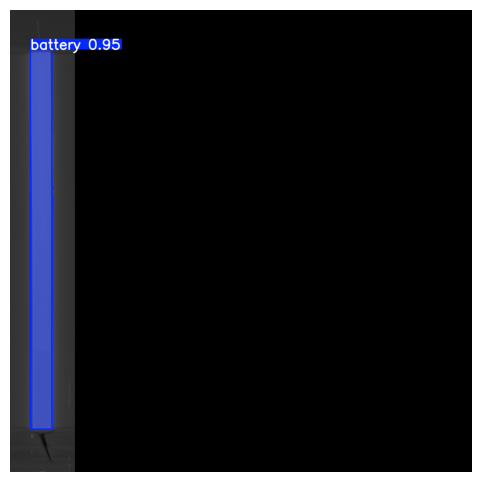

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

pred_dir = "/content/runs/segment/predict"
imgs = os.listdir(pred_dir)

img = Image.open(os.path.join(pred_dir, imgs[0]))
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")



mIOU 계산

In [ ]:
import cv2
import numpy as np
import os
from ultralytics import YOLO

MODEL_PATH = "/content/runs/segment/train/weights/best.pt"
IMG_DIR = "/content/battery_yolo/images/val"
LBL_DIR = "/content/battery_yolo/labels/val"

model = YOLO(MODEL_PATH)

def compute_iou(gt, pred):
    inter = np.logical_and(gt, pred).sum()
    union = np.logical_or(gt, pred).sum()
    return inter / union if union > 0 else 0.0

ious = []

for img_name in os.listdir(IMG_DIR):
    if not img_name.endswith(".jpg"):
        continue

    img_path = os.path.join(IMG_DIR, img_name)
    label_path = os.path.join(LBL_DIR, img_name.replace(".jpg", ".txt"))

    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    # GT mask
    gt = np.zeros((h, w), dtype=np.uint8)
    with open(label_path) as f:
        for line in f:
            p = list(map(float, line.split()))
            poly = np.array(p[1:], dtype=np.float32).reshape(-1, 2)
            poly[:, 0] *= w
            poly[:, 1] *= h
            cv2.fillPoly(gt, [poly.astype(np.int32)], 1)

    # Pred mask
    r = model(img_path, imgsz=1024, conf=0.25, verbose=False)[0]
    if r.masks is None:
        pred = np.zeros((h, w), dtype=np.uint8)
    else:
        pred = r.masks.data[0].cpu().numpy()
        pred = cv2.resize(pred, (w, h))
        pred = (pred > 0.5).astype(np.uint8)

    ious.append(compute_iou(gt, pred))

print("mIoU:", sum(ious) / len(ious))
